Trovati 2 file DICOM

Informazioni DICOM:
Dimensioni immagine: 128 x 128
Tipo di acquisizione: Non specificato
Numero totale di frames: 120


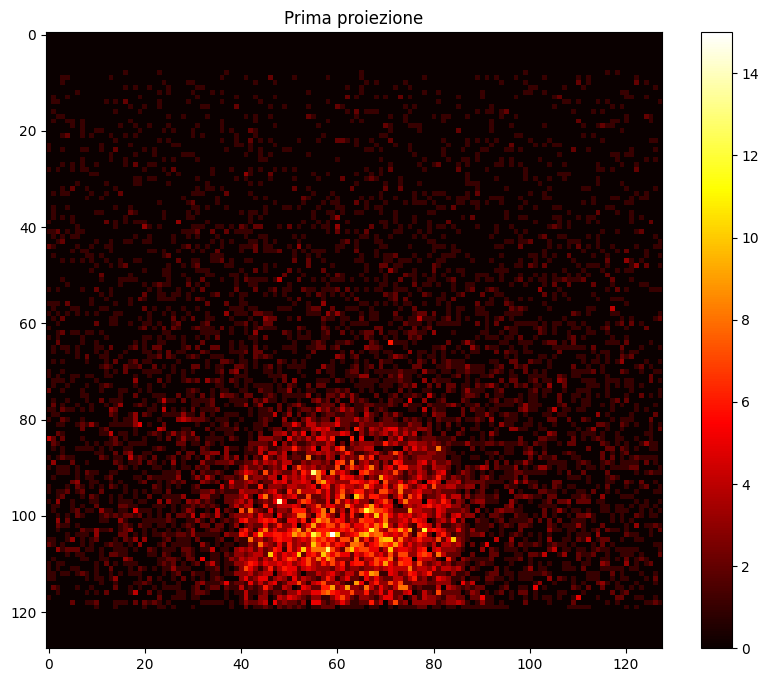

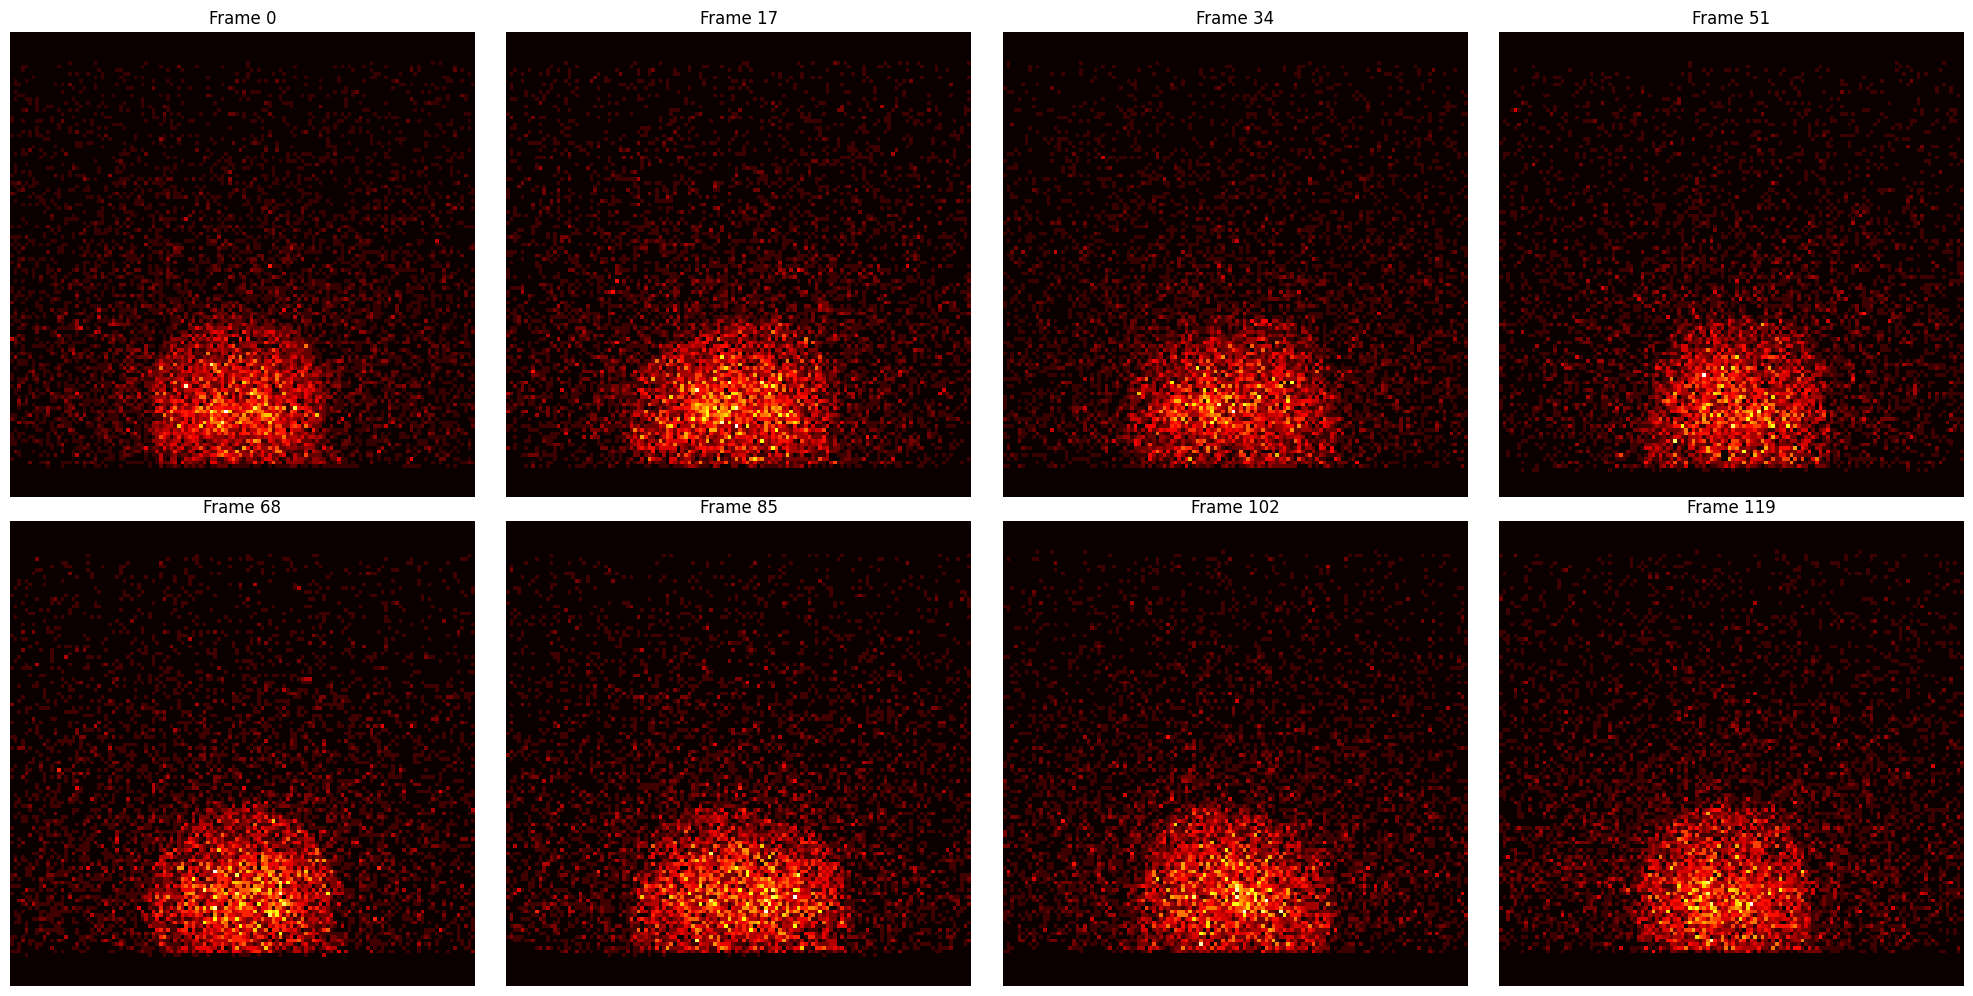


Shape dei dati: (120, 128, 128)
Tipo di dati: uint16
Range dei valori: 0 - 19


In [1]:
import os
import numpy as np
import pydicom
import matplotlib.pyplot as plt
from pathlib import Path

def explore_dicom_data():
    # Directory contenente le immagini DICOM
    image_dir = Path("Images")
    
    # Lista tutti i file DICOM nella directory
    dicom_files = list(image_dir.glob("*.dcm"))
    
    print(f"Trovati {len(dicom_files)} file DICOM")
    
    # Leggi il primo file per esplorarne le caratteristiche
    if dicom_files:
        ds = pydicom.dcmread(dicom_files[0])
        
        # Stampa informazioni importanti
        print("\nInformazioni DICOM:")
        print(f"Dimensioni immagine: {ds.Rows} x {ds.Columns}")
        print(f"Tipo di acquisizione: {ds.get('AcquisitionType', 'Non specificato')}")
        print(f"Numero totale di frames: {ds.get('NumberOfFrames', 'Non specificato')}")
        
        # Ottieni i dati dell'immagine
        pixel_array = ds.pixel_array
        
        # Se abbiamo multiple frames, mostriamo la prima
        if len(pixel_array.shape) > 2:
            first_frame = pixel_array[0]
        else:
            first_frame = pixel_array
            
        # Visualizza la prima proiezione
        plt.figure(figsize=(10, 8))
        plt.imshow(first_frame, cmap='hot')
        plt.colorbar()
        plt.title("Prima proiezione")
        plt.show()
        
        # Se abbiamo multiple frames, mostriamo anche una vista d'insieme
        if len(pixel_array.shape) > 2:
            num_frames = pixel_array.shape[0]
            fig, axes = plt.subplots(2, 4, figsize=(20, 10))
            frames_to_show = np.linspace(0, num_frames-1, 8, dtype=int)
            
            for i, ax in enumerate(axes.flat):
                if i < len(frames_to_show):
                    ax.imshow(pixel_array[frames_to_show[i]], cmap='hot')
                    ax.set_title(f'Frame {frames_to_show[i]}')
                ax.axis('off')
            
            plt.tight_layout()
            plt.show()
            
        return ds, pixel_array
    
    return None, None

if __name__ == "__main__":
    ds, pixel_array = explore_dicom_data()
    
    if ds is not None:
        print("\nShape dei dati:", pixel_array.shape)
        print("Tipo di dati:", pixel_array.dtype)
        print("Range dei valori:", pixel_array.min(), "-", pixel_array.max())

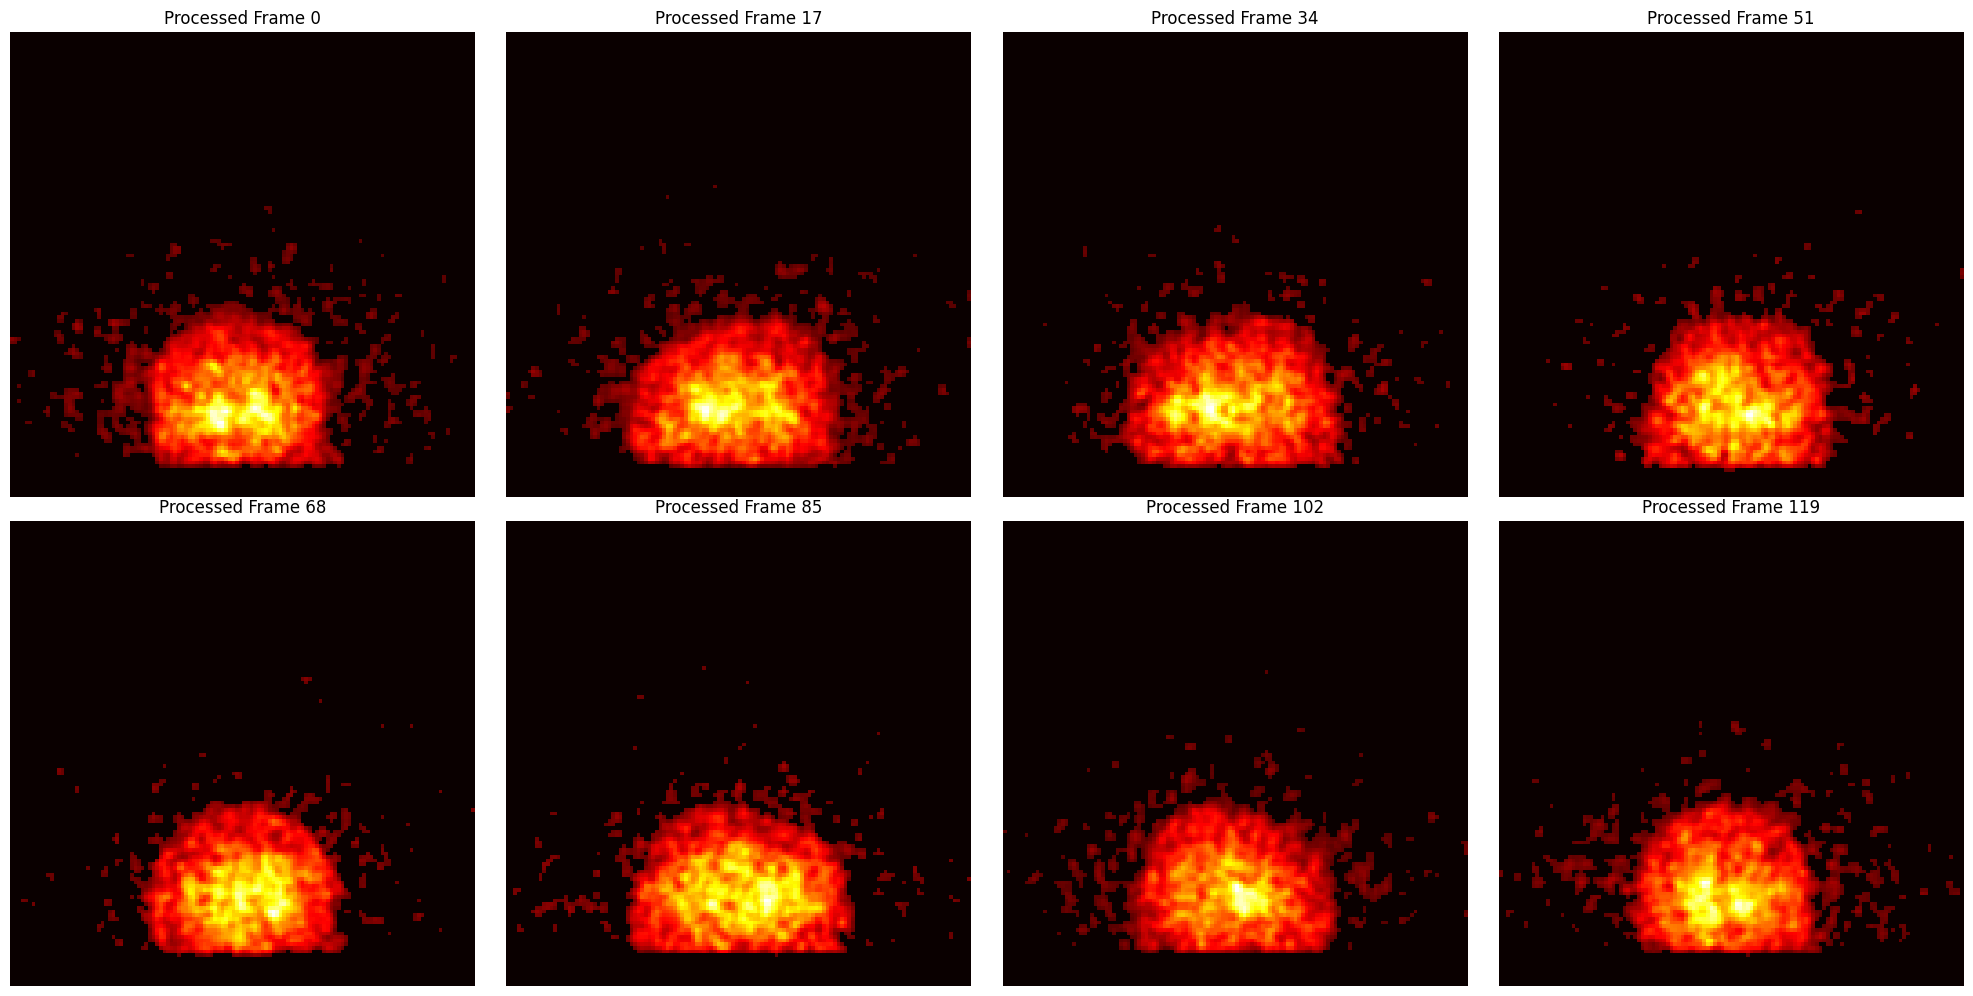

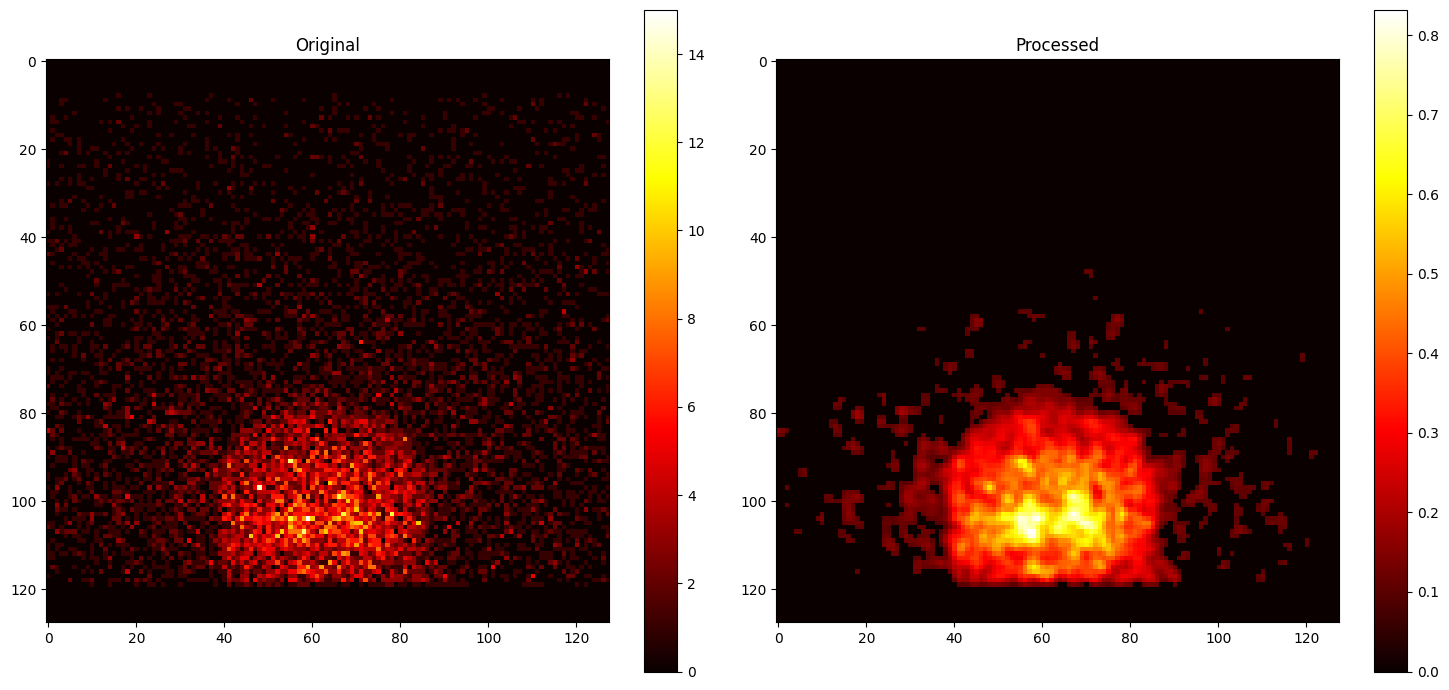

In [2]:
import numpy as np
from scipy import ndimage
import matplotlib.pyplot as plt

def preprocess_projections(pixel_array):
    """
    Preprocess SPECT projections:
    1. Apply Gaussian smoothing to reduce noise
    2. Normalize values
    3. Apply threshold to remove background noise
    """
    # Crea una copia dei dati
    processed = pixel_array.astype(float)
    
    # Applica smoothing Gaussiano a ogni proiezione
    for i in range(processed.shape[0]):
        processed[i] = ndimage.gaussian_filter(processed[i], sigma=1.0)
    
    # Normalizza i valori
    processed = (processed - processed.min()) / (processed.max() - processed.min())
    
    # Applica una soglia per rimuovere il rumore di fondo
    threshold = 0.1  # questo valore può essere aggiustato
    processed[processed < threshold] = 0
    
    # Visualizza alcune proiezioni preprocessate
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    frames_to_show = np.linspace(0, processed.shape[0]-1, 8, dtype=int)
    
    for i, ax in enumerate(axes.flat):
        if i < len(frames_to_show):
            ax.imshow(processed[frames_to_show[i]], cmap='hot')
            ax.set_title(f'Processed Frame {frames_to_show[i]}')
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return processed

# Funzione per visualizzare il confronto prima/dopo
def show_comparison(original, processed, frame_idx=0):
    """
    Mostra il confronto tra proiezione originale e preprocessata
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    im1 = ax1.imshow(original[frame_idx], cmap='hot')
    ax1.set_title('Original')
    plt.colorbar(im1, ax=ax1)
    
    im2 = ax2.imshow(processed[frame_idx], cmap='hot')
    ax2.set_title('Processed')
    plt.colorbar(im2, ax=ax2)
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    # Carica i dati come prima
    image_dir = Path("Images")
    dicom_files = list(image_dir.glob("*.dcm"))
    ds = pydicom.dcmread(dicom_files[0])
    pixel_array = ds.pixel_array
    
    # Applica il preprocessing
    processed_projections = preprocess_projections(pixel_array)
    
    # Mostra il confronto per la prima proiezione
    show_comparison(pixel_array, processed_projections)

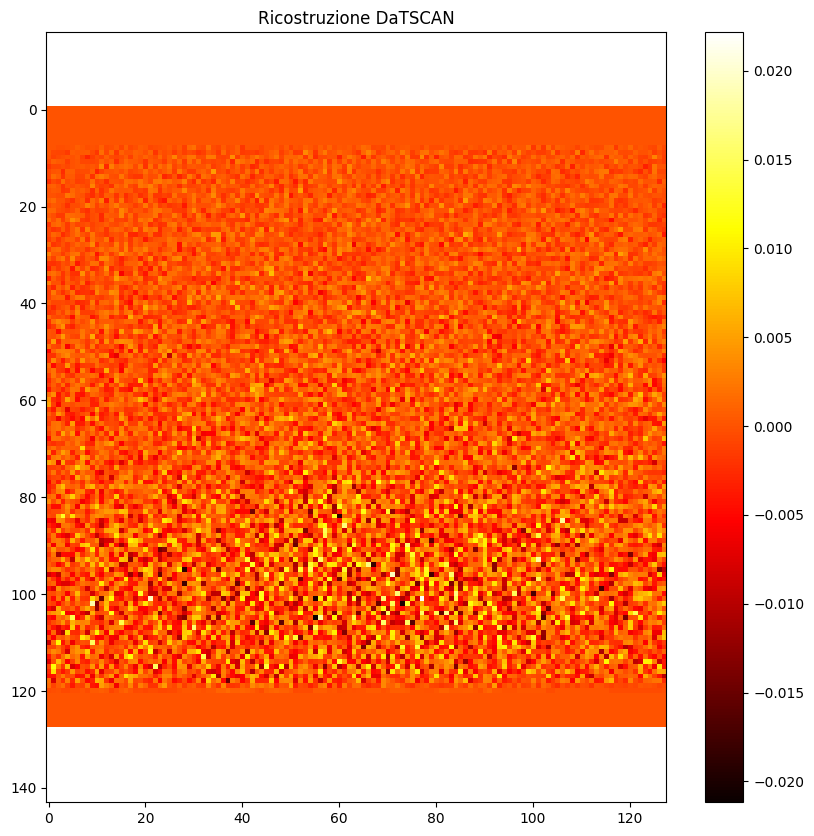

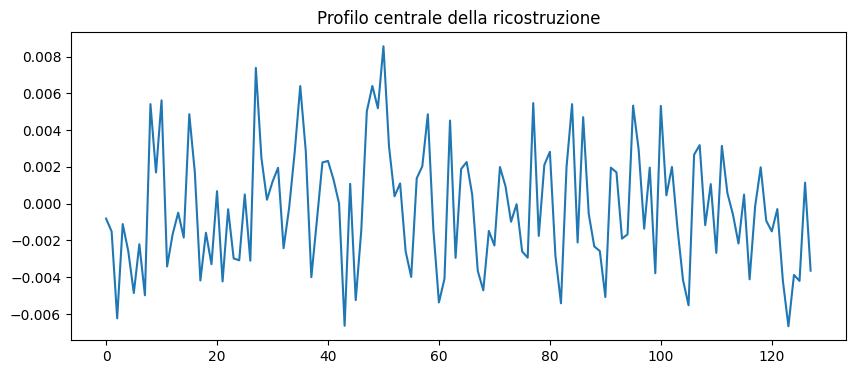

In [7]:
import numpy as np
from scipy.fft import fft, ifft, fftfreq
import matplotlib.pyplot as plt

def filtered_backprojection_2d(projections):
    """
    Implementa la FBP per DaTSCAN
    
    Args:
        projections: array di proiezioni (120, 128, 128)
    Returns:
        reconstruction: immagine ricostruita (128, 128)
    """
    num_angles, height, width = projections.shape
    angles = np.linspace(0, np.pi, num_angles)
    
    # Centro dell'immagine
    center = width // 2
    
    # Crea griglia di coordinate per la ricostruzione
    x = np.arange(width) - center
    y = np.arange(height) - center
    X, Y = np.meshgrid(x, y)
    reconstruction = np.zeros((height, width))
    
    # Step 1: Filtraggio delle proiezioni
    filtered_projections = np.zeros_like(projections, dtype=float)
    freqs = fftfreq(width)
    ramp_filter = 2 * np.abs(freqs)  # Filtro rampa
    
    for angle_idx in range(num_angles):
        # Applica il filtro nel dominio delle frequenze
        for row in range(height):
            proj_fft = fft(projections[angle_idx, row])
            filtered_projections[angle_idx, row] = np.real(ifft(proj_fft * ramp_filter))
    
    # Step 2: Back-projection
    for angle_idx, theta in enumerate(angles):
        # Calcola le coordinate ruotate
        t = X * np.cos(theta) + Y * np.sin(theta)
        
        # Per ogni punto nella griglia di output
        for i in range(height):
            for j in range(width):
                # Trova l'indice più vicino nella proiezione
                k = int(round(t[i, j] + center))
                if 0 <= k < width:
                    reconstruction[i, j] += filtered_projections[angle_idx, i, k]
    
    # Normalizza
    reconstruction *= np.pi / (2 * num_angles)
    return reconstruction

def visualize_reconstruction(reconstruction):
    """
    Visualizza il risultato della ricostruzione
    """
    plt.figure(figsize=(10, 10))
    plt.imshow(reconstruction, cmap='hot')
    plt.colorbar()
    plt.title('Ricostruzione DaTSCAN')
    plt.axis('equal')
    plt.show()
    
    # Mostra anche un profilo centrale
    center_slice = reconstruction[reconstruction.shape[0]//2, :]
    plt.figure(figsize=(10, 4))
    plt.plot(center_slice)
    plt.title('Profilo centrale della ricostruzione')
    plt.show()

if __name__ == "__main__":
    # Carica i dati
    image_dir = Path("Images")
    dicom_files = list(image_dir.glob("*.dcm"))
    ds = pydicom.dcmread(dicom_files[0])
    projections = ds.pixel_array
    
    # Normalizza le proiezioni
    projections = projections.astype(float)
    projections = (projections - projections.min()) / (projections.max() - projections.min())
    
    # Ricostruzione
    reconstruction = filtered_backprojection_2d(projections)
    
    # Visualizzazione
    visualize_reconstruction(reconstruction)

In [5]:
def post_process_reconstruction(reconstructed_image):
    """
    Applica il post-processing all'immagine ricostruita
    """
    # Normalizzazione
    processed = (reconstructed_image - reconstructed_image.min()) / (reconstructed_image.max() - reconstructed_image.min())
    
    # Denoising gaussiano
    processed = ndimage.gaussian_filter(processed, sigma=1.0)
    
    # Visualizza confronto
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7))
    
    ax1.imshow(reconstructed_image, cmap='hot')
    ax1.set_title('Ricostruzione originale')
    
    ax2.imshow(processed, cmap='hot')
    ax2.set_title('Dopo post-processing')
    
    plt.tight_layout()
    plt.show()
    
    return processed